In [15]:
import torch
import pandas as pd
import numpy as np
import albumentations as ATransforms
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
# from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF

import os
from tqdm import tqdm
from PIL import Image
import logging as log
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [17]:
log.basicConfig( level=log.DEBUG)

## Hyperparameters

In [18]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_WORKERS = 4

LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_FILE = "../models/model-1.pth"

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3


## Model Architecture

In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [47]:
class UNET(nn.Module):
    def __init__(self, in_channels=IMAGE_CHANNELS, out_channels=IMAGE_CHANNELS):
        super(UNET, self).__init__()
        self.conv1 = DoubleConv(in_channels, 64)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = DoubleConv(1024, 512)
        self.conv7 = DoubleConv(512, 256) 
        self.conv8 = DoubleConv(256, 128)
        self.conv9 = DoubleConv(128, 64)

        self.tconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(1024, 1024)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        c1 = self.conv1(x)
        skip_connections.append(c1)
        c2 = self.conv2(self.maxpool(c1))
        skip_connections.append(c2)
        c3 = self.conv3(self.maxpool(c2))
        skip_connections.append(c3)
        c4 = self.conv4(self.maxpool(c3))
        skip_connections.append(c4)
        out = self.conv5(self.maxpool(c4))
        out = self.bottleneck(out) # bottleneck shape - [1, 1024, 8, 8]
        skip_connections = skip_connections[::-1]
        out = self.tconv1(out)
        # if out.shape != skip_connections[0].shape:
        #     out = TF.resize(out, size=skip_connections[0].shape[2:])
        out = torch.cat([out, skip_connections[0]], dim=1)
        out = self.conv6(out)

        out = self.tconv2(out)
        # if out.shape != skip_connections[1].shape:
        #     out = TF.resize(out, size=skip_connections[1].shape[2:])
        out = torch.cat((out, skip_connections[1]), dim=1)
        out = self.conv7(out)

        out = self.tconv3(out)
        # if out.shape != skip_connections[2].shape:
        #     out = TF.resize(out, size=skip_connections[2].shape[2:])
        out = torch.cat((out, skip_connections[2]), dim=1)
        out = self.conv8(out)

        out = self.tconv4(out)
        # if out.shape != skip_connections[3].shape:
        #     out = TF.resize(out, size=skip_connections[3].shape[2:])
        out = torch.cat((out, skip_connections[3]), dim=1)
        out = self.conv9(out)

        out = self.out(out)
        return out
    

## Dataloader Preparation

In [48]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, normalize=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.normalize = normalize
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask > 0] = 1 # try with mask == 255.0
        if self.normalize is not None:
            norm_image = self.normalize(image=image)
            image = norm_image["image"]
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [49]:
augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ATransforms.Rotate(limit=35, p=1.0),
    ATransforms.HorizontalFlip(p=0.5),
    ATransforms.VerticalFlip(p=0.1),
    ToTensorV2(),
])

normalization = ATransforms.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            )

val_augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

In [50]:
train_loader = DataLoader(
    PolypDataset('../data/train/images/', '../data/train/masks', transform=augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    PolypDataset('../data/val/images/', '../data/val/masks', transform=val_augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    PolypDataset('../data/test/images/', '../data/test/masks'),
    batch_size = 1,
    shuffle = True,
    num_workers=NUM_WORKERS
)

## Train

In [51]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
if LOAD_MODEL : model.load_state_dict(torch.load(CHECKPOINT_FILE, map_location=DEVICE), strict=False)

In [56]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, bce=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.bce = bce

    def forward(self, pred, target):
        loss = self.IoU(pred, target) # IoU score
        loss = 1 - loss.mean() # mean over the batch
        if self.bce:
            criterion = nn.BCEWithLogitsLoss()
            bce = criterion(pred, target)
            loss += bce.mean()
        return loss
        
    def IoU(self, pred, target):
        intersection = ((pred * target) + self.smooth).sum(dim=(1,2)) # we are passing as batch of images, so sum only across height and width
        union = (pred + target + self.smooth).sum(dim=(1,2))
        return (intersection + self.smooth) / (union - intersection + self.smooth)

In [57]:
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-7)


In [58]:
def train():
    all_losses = []
    all_val_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        print(f"Epoch {epoch+1}/{EPOCHS}")
        model.train()
        for data, targets in tqdm(train_loader, colour="GREEN",unit="batch", desc="Train"):
            data = data.to(device=DEVICE)
            # targets = targets.float().unsqueeze(1).to(device=DEVICE)
            targets = targets.unsqueeze(1).to(DEVICE) # add channels dimension
            scores = model(data)
            loss = criterion(scores, targets)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        all_losses.append(total_loss/BATCH_SIZE)
        # torch.save(model.state_dict(), CHECKPOINT_FILE)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for image, mask in tqdm(val_loader, desc="Valid", colour="YELLOW", unit="batch"):
                image = image.to(device=DEVICE)
                mask = mask.unsqueeze(1).to(DEVICE)
                pred = model(image)
                # pred = torch.sigmoid(model(image))
                # preds = (preds > 0.5).float()
                loss = criterion(pred, mask)
                total_val_loss += loss.item()
        all_val_losses.append(total_val_loss/BATCH_SIZE)
        print(f"Train loss: {total_loss/len(train_loader)}, Val loss: {total_val_loss/len(val_loader)}\n")

    return all_losses, all_val_losses



In [59]:
train_loss, val_loss = train()
print("Training Done!")

Epoch 1/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.83batch/s]


Train loss: 0.38851375475762384, Val loss: 0.3315031869070871

Epoch 2/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.76batch/s]


Train loss: 0.3750635376052251, Val loss: 0.27350365264075144

Epoch 3/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.87batch/s]


Train loss: 0.36272934457612416, Val loss: 0.30230838911873953

Epoch 4/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.85batch/s]


Train loss: 0.3515762932716854, Val loss: 0.23521581505026137

Epoch 5/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.66batch/s]


Train loss: 0.3418870923065004, Val loss: 0.23325745122773306

Epoch 6/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.78batch/s]


Train loss: 0.32977557087701465, Val loss: 0.25192359941346304

Epoch 7/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.65batch/s]


Train loss: 0.3233567126213558, Val loss: 0.24254154307501657

Epoch 8/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.74batch/s]


Train loss: 0.3143806474076377, Val loss: 0.2287133527653558

Epoch 9/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.97batch/s]


Train loss: 0.30740684933132595, Val loss: 0.20400504767894745

Epoch 10/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.68batch/s]


Train loss: 0.30574136452069356, Val loss: 0.21200646460056305

Epoch 11/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.79batch/s]


Train loss: 0.30231834143873243, Val loss: 0.23501286336353847

Epoch 12/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.63batch/s]


Train loss: 0.2906979284589253, Val loss: 0.2168352178164891

Epoch 13/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.82batch/s]


Train loss: 0.2794293098979526, Val loss: 0.21988457654203689

Epoch 14/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.66batch/s]


Train loss: 0.2762565707403516, Val loss: 0.22014708817005157

Epoch 15/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.74batch/s]


Train loss: 0.27160483456793283, Val loss: 0.35723374996866497

Epoch 16/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.74batch/s]


Train loss: 0.2651089999883894, Val loss: 0.25084353557654787

Epoch 17/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.80batch/s]


Train loss: 0.26079979491612265, Val loss: 0.20447471737861633

Epoch 18/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.71batch/s]


Train loss: 0.2592879141133929, Val loss: 0.22551613407475607

Epoch 19/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.76batch/s]


Train loss: 0.25106609884708647, Val loss: 0.3113774614674704

Epoch 20/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.82batch/s]


Train loss: 0.2458302690869286, Val loss: 0.1766261841569628

Epoch 21/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.62batch/s]


Train loss: 0.24053717440082914, Val loss: 0.20599053587232316

Epoch 22/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.71batch/s]


Train loss: 0.2397778415017658, Val loss: 0.1611720791884831

Epoch 23/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.68batch/s]


Train loss: 0.23182251836572373, Val loss: 0.17404540096010482

Epoch 24/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.79batch/s]


Train loss: 0.23210574379042972, Val loss: 0.15992814408881323

Epoch 25/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.86batch/s]


Train loss: 0.21997427609231737, Val loss: 0.19603152785982406

Epoch 26/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.68batch/s]


Train loss: 0.22530936248718747, Val loss: 0.18589156014578684

Epoch 27/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.57batch/s]


Train loss: 0.21701009405983818, Val loss: 0.18434109219482966

Epoch 28/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.70batch/s]


Train loss: 0.21752005058621604, Val loss: 0.1941784598997661

Epoch 29/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.52batch/s]


Train loss: 0.21345437093386574, Val loss: 0.17614535348755972

Epoch 30/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.76batch/s]


Train loss: 0.20591476110238877, Val loss: 0.1538435806121145

Epoch 31/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.94batch/s]


Train loss: 0.20512106044897957, Val loss: 0.15103808045387268

Epoch 32/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.74batch/s]


Train loss: 0.20359647865333255, Val loss: 0.16392352538449423

Epoch 33/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.88batch/s]


Train loss: 0.19851396362932902, Val loss: 0.1587614683168275

Epoch 34/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.86batch/s]


Train loss: 0.1955441960266658, Val loss: 0.1596399268933705

Epoch 35/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.83batch/s]


Train loss: 0.1884614115669614, Val loss: 0.140126605119024

Epoch 36/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.60batch/s]


Train loss: 0.1913436059913938, Val loss: 0.1484332914863314

Epoch 37/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.89batch/s]


Train loss: 0.1913200748108682, Val loss: 0.13580738327332906

Epoch 38/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.87batch/s]


Train loss: 0.1830467035373052, Val loss: 0.13194566539355687

Epoch 39/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.81batch/s]


Train loss: 0.18038085091208655, Val loss: 0.11924968447004046

Epoch 40/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.77batch/s]


Train loss: 0.17965347899330986, Val loss: 0.1683145080293928

Epoch 41/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.72batch/s]


Train loss: 0.17749548833521586, Val loss: 0.13356988451310567

Epoch 42/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.82batch/s]


Train loss: 0.18047422194291676, Val loss: 0.12243444046803884

Epoch 43/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.76batch/s]


Train loss: 0.1741989172167248, Val loss: 0.1151442261678832

Epoch 44/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.66batch/s]


Train loss: 0.17280857442390352, Val loss: 0.12149458697863988

Epoch 45/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.67batch/s]


Train loss: 0.17261891575559737, Val loss: 0.11306733318737575

Epoch 46/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.69batch/s]


Train loss: 0.17337189165372696, Val loss: 0.11603914307696479

Epoch 47/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.69batch/s]


Train loss: 0.16965267748113663, Val loss: 0.11902986360447747

Epoch 48/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.79batch/s]


Train loss: 0.1719319871257222, Val loss: 0.12688052654266357

Epoch 49/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.73batch/s]


Train loss: 0.17045978776046208, Val loss: 0.11411564158541816

Epoch 50/50


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.82batch/s]

Train loss: 0.17272903651945173, Val loss: 0.1241923166172845

Training Done!


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


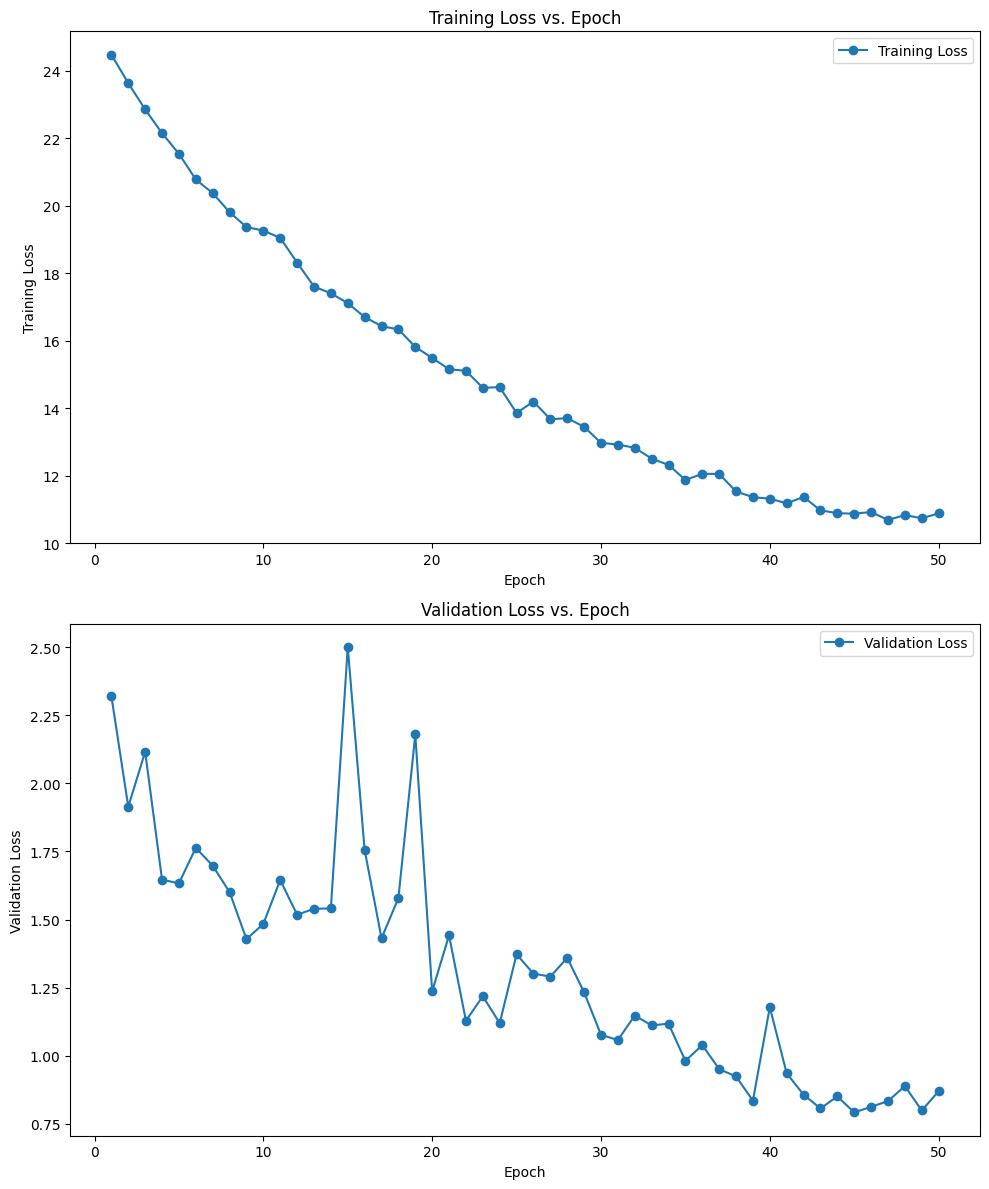

In [60]:
def plot_losses(train_loss, validation_loss):
    # Create an array of epoch numbers based on the length of the lists
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots for train loss, validation loss, and BLEU scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot training loss
    ax1.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss vs. Epoch')
    ax1.legend()

    # Plot validation loss
    ax2.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss vs. Epoch')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_losses(train_loss, val_loss)

In [ ]:
torch.save(model.state_dict(), '../models/model-1.pth')

## Test

In [ ]:
# def evaluate(model, loader):
#     model.eval()
#     total = 0
#     correct = 0
#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(DEVICE)
#             y = y.unsqueeze(1).to(DEVICE)
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#             total += y.flatten().size(0)
#             correct += (preds == y).float().sum().item()
#     return correct / total